# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [758]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [759]:
# load weekly sales dataset

filename = "~/Documents/feature-engineering-for-time-series-forecasting/feature-engineering-for-time-series-forecasting-main/02-Tabularizing-Time-Series/Datasets/online_retail_dataset.csv"


df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head(n=22)

,sales
week,
2009-12-06,213000.350
2009-12-13,195810.040
2009-12-20,182396.740
2009-12-27,22007.770
2010-01-03,0.000
2010-01-10,112318.850
2010-01-17,111460.470
2010-01-24,82065.331
2010-01-31,110790.591


# Data analysis

First, explore the time series.



In [760]:
df.head(n=6)

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
2010-01-10,112318.85


In [761]:
#Sanity check: data span

df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [762]:
print(df.columns)

Index(['sales'], dtype='object')


## Plot time series

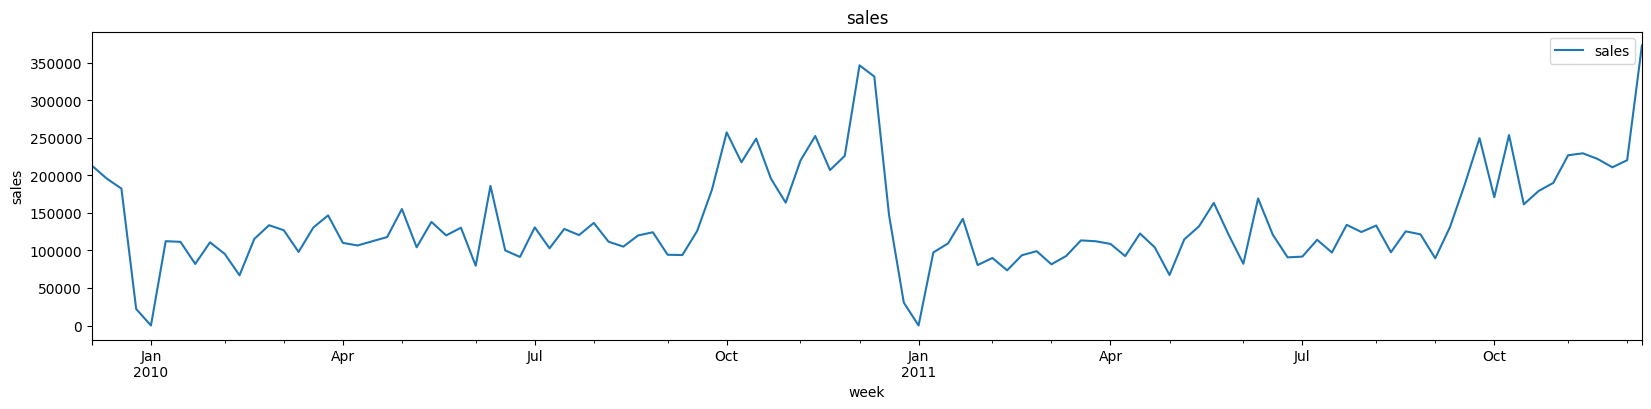

In [763]:
df.plot( figsize=(20,4) )
# Add title
plt.title('sales')
# the y axis label
plt.ylabel('sales')

plt.show()

In [764]:
#Remove outliers

df = df.loc[(df.sales>0)]


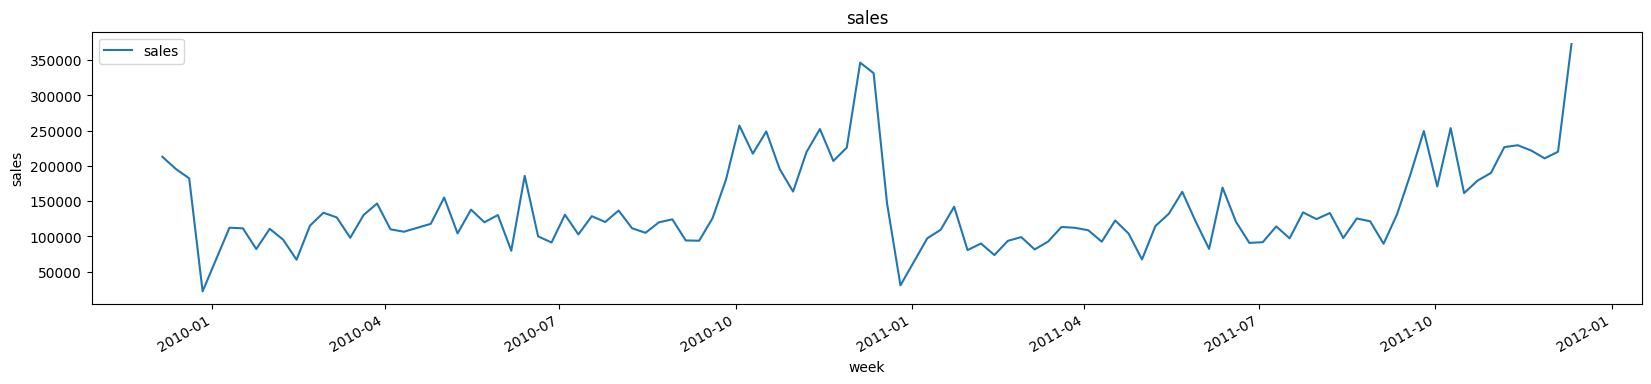

In [765]:
#Plot the time series

df.plot( figsize=(20,4) )
# Add title
plt.title('sales')
# the y axis label
plt.ylabel('sales')

plt.show()

In [766]:
df.head(15)

,sales
week,
2009-12-06,213000.350
2009-12-13,195810.040
2009-12-20,182396.740
2009-12-27,22007.770
2010-01-10,112318.850
2010-01-17,111460.470
2010-01-24,82065.331
2010-01-31,110790.591
2010-02-07,95340.552


## Missing data

Check if there are missing values in the time series.

In [767]:
#Quick check: missing data

df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

/tmp/ipykernel_13948/1420764395.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df_.fillna(method = "ffill")


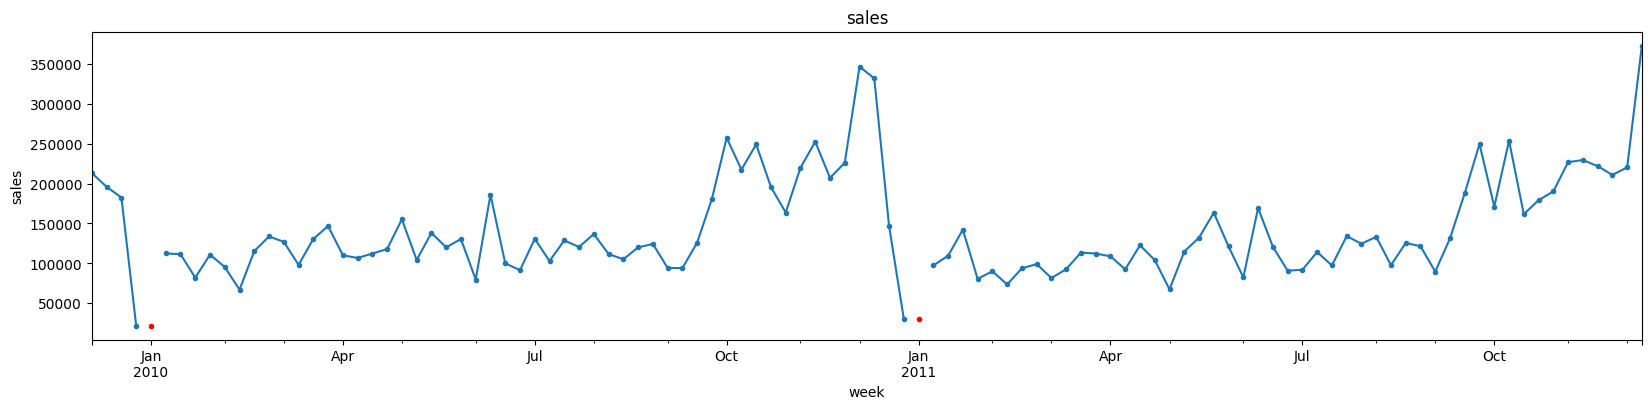

In [768]:
# Introduce the missing timestamps.
# Note that we capture this in a different dataframe.
df_ = df.asfreq("1w")


# Apply the forward fill method.
df_imputed = df_.fillna(method = "ffill")

# Plot the imputed time series.
ax = df_["sales"].plot(linestyle = "-", marker = ".", figsize = [20,4])

# plot the imputed values on top, in red.
df_imputed[df_.isnull()]["sales"].plot(ax = ax, legend = None, marker = ".", color = "r")

# Add title
plt.title('sales')

# the y axis label
plt.ylabel('sales')

plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

In [769]:
#Let's see if there is weekly seadonal pattern in the time series
    
day_th = df.index.day
week_ = ((week_ - 1) // 7) + 1
week_= pd.Series(week_, index = df.index)
week_.head()

week
2009-12-06    1
2009-12-13    2
2009-12-20    3
2009-12-27    4
2010-01-10    2
Name: week, dtype: int32

Text(0, 0.5, ' weekly sales Average')

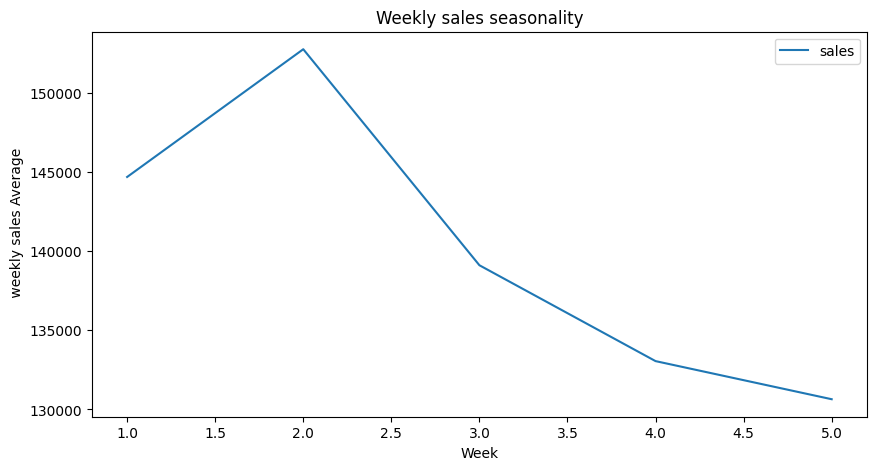

In [770]:
# Plot the average pollutant concentration per week.

df.groupby(week_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Weekly sales seasonality")
# the y axis label
plt.xlabel('Week')
# the y axis label
plt.ylabel(" weekly sales Average")

According to "week sales seasonality figure", we have more sales in the first two weeks and few sales in last three weeks.

In [771]:
month_ = df.index.month
print(month_)
month_ = pd.Series(month_, index = df.index)
month_.head()

Index([12, 12, 12, 12,  1,  1,  1,  1,  2,  2,
       ...
       10, 10, 10, 10, 11, 11, 11, 11, 12, 12],
      dtype='int32', name='week', length=104)


week
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-10     1
Name: week, dtype: int32

Text(0, 0.5, 'monthly sales Average')

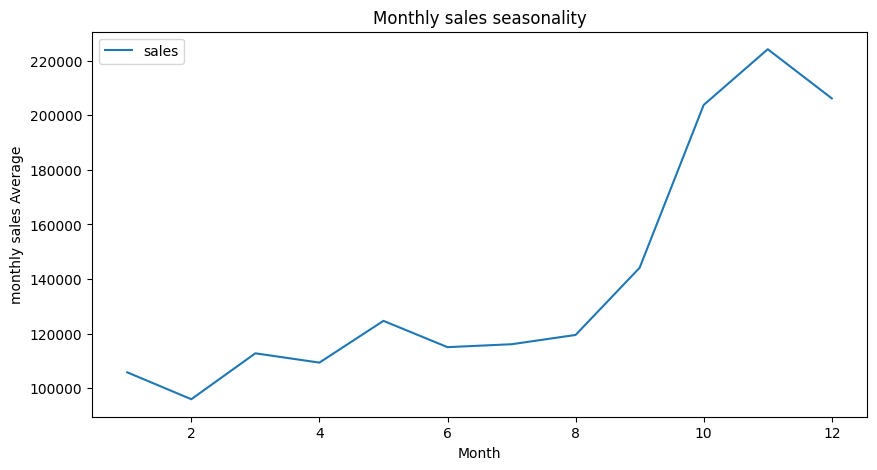

In [772]:
# Plot the average pollutant concentration per month.

df.groupby(month_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Monthly sales seasonality")
# the y axis label
plt.xlabel('Month')
# the y axis label
plt.ylabel("monthly sales Average")

According to "Monthly sales seasonality", there is few sales in the begining of the year and high sales in end of year.

In [773]:
week_ = df.index.day
print(week_)
print(week_ -1)
(week_ -1) // 7 + 1
#month_ = pd.Series(month_, index = df.index)
#month_.head()

Index([ 6, 13, 20, 27, 10, 17, 24, 31,  7, 14,
       ...
        9, 16, 23, 30,  6, 13, 20, 27,  4, 11],
      dtype='int32', name='week', length=104)
Index([ 5, 12, 19, 26,  9, 16, 23, 30,  6, 13,
       ...
        8, 15, 22, 29,  5, 12, 19, 26,  3, 10],
      dtype='int32', name='week', length=104)


Index([1, 2, 3, 4, 2, 3, 4, 5, 1, 2,
       ...
       2, 3, 4, 5, 1, 2, 3, 4, 1, 2],
      dtype='int32', name='week', length=104)

In [774]:
year_ = df.index.year
print(year_)
year_ = pd.Series(year_, index = df.index)
year_.head()

Index([2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010, 2010,
       ...
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011],
      dtype='int32', name='week', length=104)


week
2009-12-06    2009
2009-12-13    2009
2009-12-20    2009
2009-12-27    2009
2010-01-10    2010
Name: week, dtype: int32

Text(0, 0.5, 'yearly sales Average')

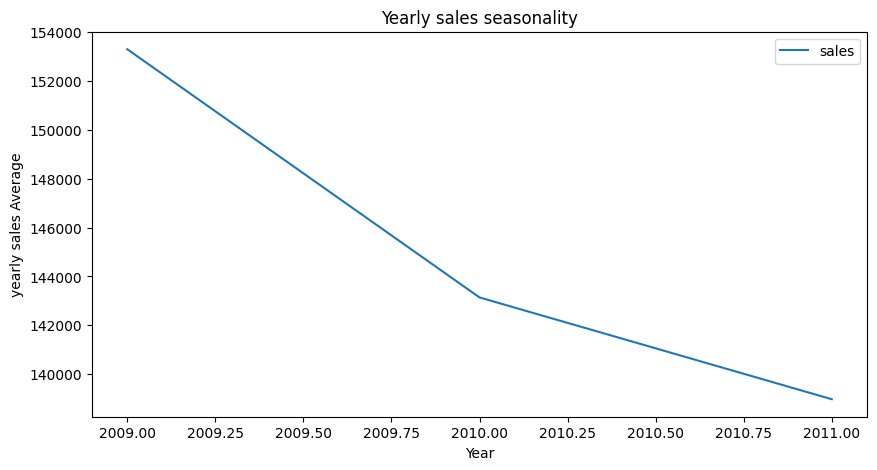

In [775]:
# Plot the average pollutant concentration per year.

df.groupby(year_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Yearly sales seasonality")
# the y axis label
plt.xlabel('Year')
# the y axis label
plt.ylabel("yearly sales Average")

According to "yearly sales seasonality" figure, there is few sales in the 2010 and 2011 and also there is of the high sales in 2009.

# Feature engineering

Now, let's begin to tabularize the data.

In [776]:
# Extract date and time features.

df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week


# Show new variables
df.head()

/tmp/ipykernel_13948/1225176554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df.index.month
/tmp/ipykernel_13948/1225176554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Week"] = df.index.isocalendar().week


,sales,Month,Week
week,,,
2009-12-06,213000.35,12,49
2009-12-13,195810.04,12,50
2009-12-20,182396.74,12,51
2009-12-27,22007.77,12,52
2010-01-10,112318.85,1,1


In [777]:
# Here, I show how to move the variables forward by 1 week,
# so that the pollutant concentration from the previous
# week (t-1) is aligned with the current hour (t),
# which is the forecasting point.

# raw time series
variable = ["sales"]

# Shift the data forward 1 week.
tmp = df[variable].shift(freq="1w")

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variable]

# Add the variables to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df.head(6)

df size before
(104, 3)
df size after
(104, 4)


,sales,Month,Week,sales_lag_1
week,,,,
2009-12-06,213000.35,12,49,NaN
2009-12-13,195810.04,12,50,213000.35
2009-12-20,182396.74,12,51,195810.04
2009-12-27,22007.77,12,52,182396.74
2010-01-10,112318.85,1,1,NaN
2010-01-17,111460.47,1,2,112318.85


In [778]:
df[variable].shift(1)

,sales
week,
2009-12-06,NaN
2009-12-13,213000.35
2009-12-20,195810.04
2009-12-27,182396.74
2010-01-10,22007.77
...,...
2011-11-13,226770.53
2011-11-20,229378.01
2011-11-27,221870.29


In [779]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous hour.

df.isnull().sum()

sales          0
Month          0
Week           0
sales_lag_1    3
dtype: int64

In [780]:
# Now we repeat the exercise, but this time
# the values are moved forward 4 weeks.

# Move forward 4 hrs.
tmp = df[variable].shift(freq="4w")

# Rename the variables.
tmp.columns = [v + "_lag_4" for v in variable]

# Add the features to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df.head(6)
df[["sales", "sales_lag_4"]].head(6)

df size before
(104, 4)
df size after
(104, 5)


,sales,sales_lag_4
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,NaN
2009-12-20,182396.74,NaN
2009-12-27,22007.77,NaN
2010-01-10,112318.85,195810.04
2010-01-17,111460.47,182396.74


In [781]:
df["sales"].head()

week
2009-12-06    213000.35
2009-12-13    195810.04
2009-12-20    182396.74
2009-12-27     22007.77
2010-01-10    112318.85
Name: sales, dtype: float64

In [782]:
df["sales"].tail()

week
2011-11-13    229378.01
2011-11-20    221870.29
2011-11-27    210741.76
2011-12-04    220213.99
2011-12-11    372946.26
Name: sales, dtype: float64

In [783]:
df["sales"].shift(freq="4w").head()

week
2010-01-03    213000.35
2010-01-10    195810.04
2010-01-17    182396.74
2010-01-24     22007.77
2010-02-07    112318.85
Name: sales, dtype: float64

In [784]:
df[variable].shift(freq="4w")

,sales
week,
2010-01-03,213000.35
2010-01-10,195810.04
2010-01-17,182396.74
2010-01-24,22007.77
2010-02-07,112318.85
...,...
2011-12-11,229378.01
2011-12-18,221870.29
2011-12-25,210741.76


In [785]:
df.isnull().sum()

sales          0
Month          0
Week           0
sales_lag_1    3
sales_lag_4    6
dtype: int64

In [786]:
#Window features

# Use the mean of the 3 previous weeks as input variables.

tmp = (
    df[variable]
    .rolling(window=3)
    .mean()  # Average the last 3 week values.
    .shift(freq="1w")  # Move the average 1 week forward
)

# Rename the columns
tmp.columns = [v + "_window" for v in variable]


# view of the result
tmp.head(10)

,sales_window
week,
2009-12-13,NaN
2009-12-20,NaN
2009-12-27,197069.043333
2010-01-03,133404.850000
2010-01-17,105574.453333
2010-01-24,81929.030000
2010-01-31,101948.217000
2010-02-07,101438.797333
2010-02-14,96065.491333


In [787]:
# Join the new variables to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df[["sales", "sales_window"]].head()
#df.head()

df size before
(104, 5)
df size after
(104, 6)


,sales,sales_window
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,NaN
2009-12-20,182396.74,NaN
2009-12-27,22007.77,197069.043333
2010-01-10,112318.85,NaN


In [788]:
#Periodic features

# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["Month", "Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [789]:
cyclical_vars = [var for var in df.columns if "sin" in var or "cos" in var]

df[cyclical_vars].head()

,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,
2009-12-06,-2.449294e-16,1.000000,-0.354605,0.935016
2009-12-13,-2.449294e-16,1.000000,-0.239316,0.970942
2009-12-20,-2.449294e-16,1.000000,-0.120537,0.992709
2009-12-27,-2.449294e-16,1.000000,-0.0,1.0
2010-01-10,5.000000e-01,0.866025,0.120537,0.992709


In [790]:
#Dropping missing data

# Determine fraction of missing data.

df.isnull().sum() / len(df)

sales           0.000000
Month           0.000000
Week            0.000000
sales_lag_1     0.028846
sales_lag_4     0.057692
sales_window    0.048077
Month_sin       0.000000
Month_cos       0.000000
Week_sin        0.000000
Week_cos        0.000000
dtype: float64

In [791]:
#Imputation

#There is not a lot of data missing, so I will just remove those observations.

print("df size before")
print(df.shape)

df.dropna(inplace=True)

print("df size after")
print(df.shape)

df size before
(104, 10)
df size after
(96, 10)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [792]:
#Save preprocessed data

df.head()

,sales,Month,Week,sales_lag_1,sales_lag_4,sales_window,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,,,,,,,
2010-01-17,111460.470,1,2,112318.850,182396.740,105574.453333,0.500000,0.866025,0.239316,0.970942
2010-01-24,82065.331,1,3,111460.470,22007.770,81929.030000,0.500000,0.866025,0.354605,0.935016
2010-02-07,95340.552,2,5,110790.591,112318.850,101438.797333,0.866025,0.500000,0.568065,0.822984
2010-02-14,66868.850,2,6,95340.552,111460.470,96065.491333,0.866025,0.500000,0.663123,0.748511
2010-02-21,115261.842,2,7,66868.850,82065.331,90999.997667,0.866025,0.500000,0.748511,0.663123


In [793]:
df.index.min(), df.index.max()

(Timestamp('2010-01-17 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [795]:
X_train = df[df.index <= "2011-08-01"]
X_test = df[df.index > "2011-08-01"]

X_train.shape, X_test.shape

((77, 10), (19, 10))

In [796]:
# the target variable
Y_train = X_train["sales"].copy()
Y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

In [798]:
df.head()

,sales,Month,Week,sales_lag_1,sales_lag_4,sales_window,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,,,,,,,
2010-01-17,111460.470,1,2,112318.850,182396.740,105574.453333,0.500000,0.866025,0.239316,0.970942
2010-01-24,82065.331,1,3,111460.470,22007.770,81929.030000,0.500000,0.866025,0.354605,0.935016
2010-02-07,95340.552,2,5,110790.591,112318.850,101438.797333,0.866025,0.500000,0.568065,0.822984
2010-02-14,66868.850,2,6,95340.552,111460.470,96065.491333,0.866025,0.500000,0.663123,0.748511
2010-02-21,115261.842,2,7,66868.850,82065.331,90999.997667,0.866025,0.500000,0.748511,0.663123


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [799]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    Y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    Y_test, X_test["sales_lag_1"], squared=False,))


train rmse:  44319.33033834646
test rmse:  55645.392882097716


## Machine Learning

In [800]:
#Random Forests 

rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [801]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    Y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    Y_test, rf_model.predict(X_test), squared=False,))

train rmse:  25112.698350310227
test rmse:  39976.78960784441


In [802]:
# Linear model

linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, Y_train)

/home/guy/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e+10, tolerance: 2.348e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=100, random_state=0)

In [804]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    Y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    Y_test, linear_model.predict(X_test), squared=False,))

train rmse:  35468.20868388946
test rmse:  48724.32173247362


Text(0, 0.5, 'Importance')

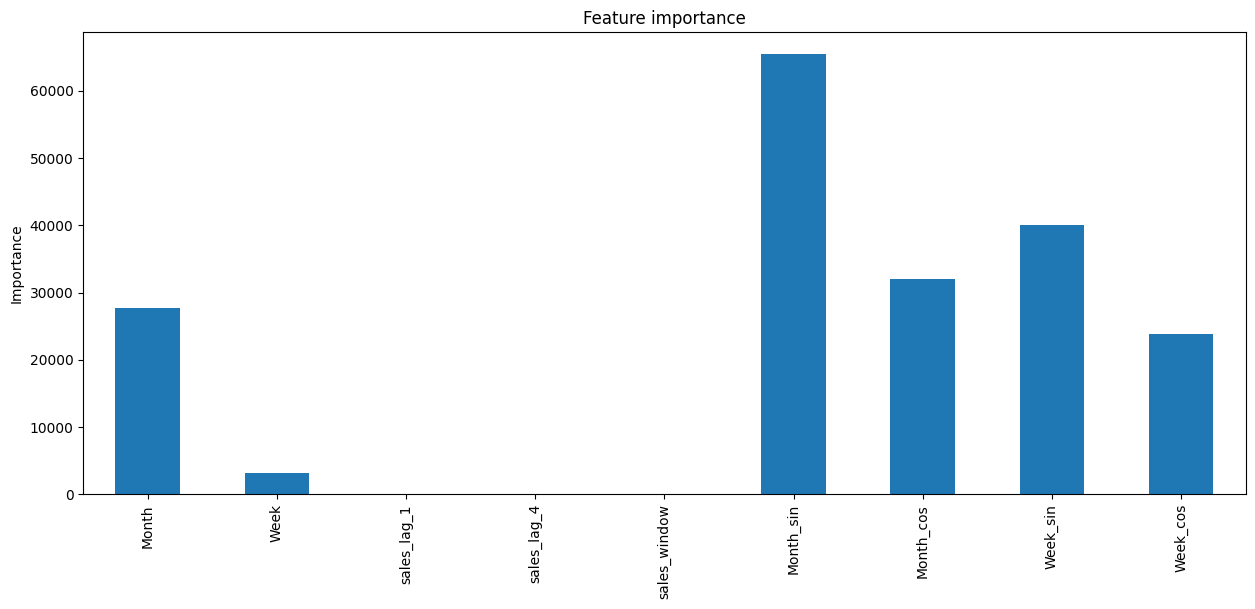

In [805]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")
